<a href="https://colab.research.google.com/github/LAOLIVEIRA1972/PUC_MVP/blob/main/mvp_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução


---

### 1.1- Objetivo
O objetivo desse projeto é criar e avaliar um modelo de Machine Learning que possa estimar a duração de paradas programadas de plataformas petrolíferas de acordo com as suas características.

### 1.2- Descrição do problema
A parada programada de uma plataforma petrolífera é um evento em que a produção de petróleo é reduzidade de forma parcial ou integral, devendo ser, dessa forma, planejada de forma a otimizar a duração do evento, a fim de minimizar o impacto na perda do volume produzido.
A duração das paradas programadas depende da complexidade e extensão da manutenção necessária, podendo variar de alguns dias a algumas semanas, ou até meses.
Alguns desses fatores serão analisados neste projeto, como: idade, tipo e propriedade da plataforma; lâmina d'água e bacia; tipo de operação (produção ou injeção).

### 1.3- Premissas
Foram consideradas apenas paradas programadas, ou seja, aquelas previstas dentro do Plano de Negócio da Empresa. Paradas não programadas não foram consideradas, como por exemplo, paradas por interdição de Órgãos reguladores.
Foram coletadas informações de paradas programadas a partir de 2012 apenas em bacias sedimentares do Sudeste.

### 1.4- Descrição do Dataset
O dataset é composto por um pouco mais de 600 registros com dados referentes a paradas programadas de uma Empresa produtora de petróleo, com as seguintes informações:
- Plataforma: identificação da plataforma.
- Tipo: tipo da plataforma (FPSO, Fixa, Semi-submersível).
- Propriedade: indica se a plataforma é própria ou afretada.
- LDA: lâmina d'água (Rasa, Produnda ou Ultraprofunda) onde a plataforma opera.
- Bacia: bacia sedimentar onde a plataforma opera.
- Restrição de queima: indica se a parada ocasionará restrição na queima.
- Tipo operação: indica se o impacto será na produção ou injeção.
- Idade: idade em anos da plataforma na parda.
- Duração: duração da parada em dias.

A variável **Duração** é uma medida quantitativa do número em dias da parada programada, ou seja, é **um problema de regressão**.

# 2. Importação de bibliotecas necessárias


---



In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
from sklearn.preprocessing import StandardScaler # algoritmo para padronização dos dados
from sklearn.preprocessing import MinMaxScaler # algoritmo para normalização dos dados
from sklearn.pipeline import Pipeline # pipeline
from sklearn.ensemble import BaggingRegressor # método de ensemble Bagging
from sklearn.ensemble import RandomForestRegressor # método de ensemble RadomForest
from sklearn.ensemble import ExtraTreesRegressor # método de ensemble ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor # método de ensemble VotingRegressor
from sklearn.ensemble import AdaBoostRegressor # método de ensemble AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor # método de ensemble GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.model_selection import GridSearchCV # para a otimização dos hiperparâmetros

# 3. Preparação dos dados


---



### 3.1- Leitura do Dataset
Como o dataset original contém atributos categóricos, será necessária a transformação destes em atributos numéricos.

In [2]:
# Informa a URL de importação do dataset (usando o link raw para o arquivo no GitHub)
url = "https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP/main/dataset_plataformas.xlsx"

# Lê o arquivo
dataset = pd.read_excel(url)

# Mostra as primeiras linhas do dataset
display(dataset.head())

# transforma atributos categóricos em numéricos
cols_cat = ["PLATAFORMA", "TIPO", "PROPRIEDADE","LDA", "BACIA", "RESTRICAO_QUEIMA", "TIPO_OPERACAO"]
for col in cols_cat:
    dataset[col] = dataset[col].replace({sorted(dataset[col].unique())[i]:i for i in range(len(sorted(dataset[col].unique())))})

# Mostra as primeiras linhas do dataset
display(dataset.head())

,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE,DURAÇÃO
0,PA04,FPSO,Afretado,P,B1,NÃO,Produção,3,9.0
1,PA05,FPSO,Afretado,P,B1,NÃO,Produção,3,14.0
2,PA05,FPSO,Afretado,P,B1,NÃO,Injeção,3,13.0
3,PA09,FPSO,Afretado,P,B1,NÃO,Produção,4,14.0
4,PA09,FPSO,Afretado,P,B1,NÃO,Produção,6,25.0


,PLATAFORMA,TIPO,PROPRIEDADE,LDA,BACIA,RESTRICAO_QUEIMA,TIPO_OPERACAO,IDADE,DURAÇÃO
0,3,1,0,0,0,0,1,3,9.0
1,4,1,0,0,0,0,1,3,14.0
2,4,1,0,0,0,0,0,3,13.0
3,8,1,0,0,0,0,1,4,14.0
4,8,1,0,0,0,0,1,6,25.0


### 3.2- Configuração da Seed Global e Parâmetros dos *ensembles*
Configuração de uma seed única para todas as bibliotecas utilizadas no projeto de forma a garantir a reprodutibilidade do código, com os mesmos resultados.

Definição dos parâmetros dos *ensembles*: num_trees e max_features

In [3]:
# Definindo uma seed global
num_seed = 7
np.random.seed(num_seed)

# Definindo parâmetros dos ensembles
num_trees = 100 # número de árvores
max_features = 3 # número de features a considerar ao procurar a melhor divisão

### 3.3- Seleção de atributos

Aplicação de métodos de feature selection para avaliação e seleção de atributos do modelo original.
Serão utlizados os seguintes métodos:
- SelectKBest
- Eliminação Recursiva de Atributos com GradienBoosting
- Eliminação Recursiva de Atributos com RandomForest
- Importância de Atributos com ExtraTree, com uso do DecisionTree

In [4]:
# separação dos atributos da target
array = dataset.values
X = array[:,0:8] # atributos
y = array[:,8] # classe (target)

# dataframe para guardar as pontuações dos modelos
df_pontuacoes = pd.DataFrame({'Atributos': dataset.columns[0:8].tolist()})

# Seleção de atributos com SelectKBest
# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
best_var = SelectKBest(score_func=f_classif, k=4)
fit = best_var.fit(X, y)
df_pontuacoes["SelectKBest"] = fit.scores_

# Eliminação Recursiva de Atributos com GradientBoosting
modelo = GradientBoostingRegressor(n_estimators=num_trees, random_state=num_seed)
rfe = RFE(modelo, n_features_to_select=1)
fit =  rfe.fit(X, y)
df_pontuacoes["ERA GB"] = fit.ranking_

# Eliminação Recursiva de Atributos com RandomForest
modelo = RandomForestRegressor(n_estimators=num_trees, max_features=max_features, random_state=num_seed)
rfe = RFE(modelo, n_features_to_select=1)
fit =  rfe.fit(X, y)
df_pontuacoes["ERA RF"] = fit.ranking_

#Importância de Atributos com ExtraTrees
modelo = DecisionTreeRegressor()
modelo.fit(X,y)
df_pontuacoes["ET"] = modelo.feature_importances_

# exibe os resultados dos modelos aplicados
print("\nScores dos Atributos Originais:")
print(df_pontuacoes)



Scores dos Atributos Originais:
          Atributos  SelectKBest  ERA GB  ERA RF        ET
0        PLATAFORMA     1.289710       1       1  0.160376
1              TIPO     1.361212       5       6  0.027341
2       PROPRIEDADE     1.730897       8       7  0.000391
3               LDA     1.478727       4       4  0.092185
4             BACIA     1.488515       3       3  0.156493
5  RESTRICAO_QUEIMA     0.598132       7       8  0.001980
6     TIPO_OPERACAO     1.059394       6       5  0.050108
7             IDADE     1.730177       2       2  0.511127


Pela análise do resultado dos scores dos atributos originais, os dois métódos de **Eliminação Recursiva de Atributos** e o de **Importância de Atributos** convergiram no ranqueamento para os quatro primeiros colocados: IDADE, PLATAFORMA, LDA e BACIA.

Será aplicado a Eliminação Recursiva de Atributos com GradientBoosting para a seleção dos quatro primeiros colocados.

In [5]:
# Eliminação Recursiva de Atributos com GradientBoosting, selecionando os quatro atributos melhor ranqueados
modelo = GradientBoostingRegressor(n_estimators=num_trees, random_state=num_seed)
rfe = RFE(modelo, n_features_to_select=4)
fit =  rfe.fit(X, y)
X = fit.transform(X)

### 3.4- Separação do dataset em conjuntos de treino e de teste


---

Aplicação do holdout para efetuar a divisão em bases de treino (80%) e teste (20%).
Separação em 10 folds para uso da validação cruzada e uso do erro quadrático médio para avaliação do desempenho.

In [6]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=num_seed) # faz a divisão em bases de treino e teste

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
scoring='neg_mean_squared_error' # usa erro quadrático médio para avaliação do desempenho da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=num_seed) # faz o particionamento em 10 folds

# 4. Modelagem e inferência


---



### 4.1- Criação e avaliação de modelos com dados da linha base

Como não há conhecimento prévio de quais algoritmos performarão bem nesse conjunto de dados, será utilizada a configuração padrão da biblioteca *scikit-learn*, ou seja, sem **variar seus hiperparâmetros**.

Além disso, para uma melhor avaliação, será aplicado o método de **validação cruzada** (10 folds) e os resultados serão comparados graficamente por meio de boxplots. Serão avaliados o MSE e o RMSE dos modelos treinados.

Serão criados os modelos com os algoritmos **regressão linear**, **regressão linear com regularização Ridge**, **regressão linear com regularização Lasso**, **KNN**, **árvore de regressão** e **SVM**.

Também serão criados os seguintes modelos *ensemble*:
*   **Bagging**
*   **Random Forest**
*   **Extra Trees**
*   **Ada Boost**
*   **Gradient Boosting**
*   **Voting**










LR: MSE 736.26 (802.14) - RMSE 27.13
Ridge: MSE 735.81 (802.33) - RMSE 27.13
Lasso: MSE 728.57 (810.84) - RMSE 26.99
KNN: MSE 745.17 (798.56) - RMSE 27.30
CART: MSE 846.32 (763.24) - RMSE 29.09
SVM: MSE 777.79 (832.04) - RMSE 27.89
Bagging: MSE 701.07 (739.61) - RMSE 26.48
RF: MSE 707.04 (756.63) - RMSE 26.59
ET: MSE 833.74 (716.07) - RMSE 28.87
Ada: MSE 817.78 (825.56) - RMSE 28.60
GB: MSE 759.46 (786.52) - RMSE 27.56
Voting: MSE 707.71 (807.38) - RMSE 26.60


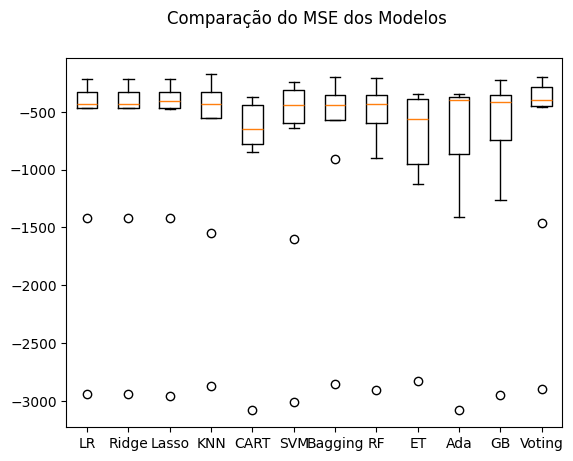

In [7]:
# Listas para armazenar os modelos, os resultados e os nomes dos modelos
modelos = []
resultados = []
nomes = []

# Preparando os modelos de regressão e adicionando-os em uma lista
modelos.append(('LR', LinearRegression()))
modelos.append(('Ridge', Ridge()))
modelos.append(('Lasso', Lasso()))
modelos.append(('KNN', KNeighborsRegressor()))
modelos.append(('CART', DecisionTreeRegressor()))
modelos.append(('SVM', SVR()))

# Definindo os parâmetros do classificador base para o BaggingRegressor
base = DecisionTreeRegressor()

# Para o VotingRegressor serão criado os modelos regressão linear, árvore de regressão e SVM
bases = []
bases.append(('logistic', LinearRegression()))
bases.append(('KNN', KNeighborsRegressor()))
bases.append(('svm', SVR()))

# Criando os ensembles e adicionando-os na lista de modelos
modelos.append(('Bagging', BaggingRegressor(estimator=base, n_estimators=num_trees, random_state=num_seed)))
modelos.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features, random_state=num_seed)))
modelos.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features, random_state=num_seed)))
modelos.append(('Ada', AdaBoostRegressor(n_estimators=num_trees, random_state=num_seed)))
modelos.append(('GB', GradientBoostingRegressor(n_estimators=num_trees, random_state=num_seed)))
modelos.append(('Voting', VotingRegressor(bases)))

# Avaliando um modelo por vez
for nome, modelo in modelos:
  cv_resultados = cross_val_score(modelo, X_treino, y_treino, cv=kfold, scoring=scoring)
  resultados.append(cv_resultados)
  nomes.append(nome)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (nome, abs(cv_resultados.mean()), cv_resultados.std(), np.sqrt(abs(cv_resultados.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

### 4.2- Criação e avalidação de modelos com dados normalizados e padronizados
O processo será repetido, utilizando a biblioteca **Pipeline** para criar e avaliar os modelos através da **validação cruzada** com os dados **padronizados** e **normalizados** (evitando o *data leakage*). Os resultados serão comparados com os modelos treinados com o dataset original.

LR-orig: MSE 736.26 (802.14) - RMSE 27.13
KNN-orig: MSE 745.17 (798.56) - RMSE 27.30
Ridge-orig: MSE 735.81 (802.33) - RMSE 27.13
Lasso-orig: MSE 728.57 (810.84) - RMSE 26.99
CART-orig: MSE 869.52 (756.65) - RMSE 29.49
SVM-orig: MSE 777.79 (832.04) - RMSE 27.89
Bag-orig: MSE 701.07 (739.61) - RMSE 26.48
RF-orig: MSE 707.04 (756.63) - RMSE 26.59
ET-orig: MSE 833.74 (716.07) - RMSE 28.87
Ada-orig: MSE 817.78 (825.56) - RMSE 28.60
GB-orig: MSE 759.46 (786.52) - RMSE 27.56
Vot-orig: MSE 707.71 (807.38) - RMSE 26.60
LR-padr: MSE 736.26 (802.14) - RMSE 27.13
KNN-padr: MSE 777.49 (768.46) - RMSE 27.88
Ridge-padr: MSE 736.04 (802.29) - RMSE 27.13
Lasso-padr: MSE 729.11 (808.26) - RMSE 27.00
CART-padr: MSE 846.07 (768.89) - RMSE 29.09
SVM-padr: MSE 763.47 (834.79) - RMSE 27.63
Bag-padr: MSE 699.62 (739.28) - RMSE 26.45
RF-padr: MSE 706.81 (757.94) - RMSE 26.59
ET-padr: MSE 833.74 (716.07) - RMSE 28.87
Ada-padr: MSE 817.49 (835.33) - RMSE 28.59
GB-padr: MSE 760.58 (786.52) - RMSE 27.58
Vot-padr:

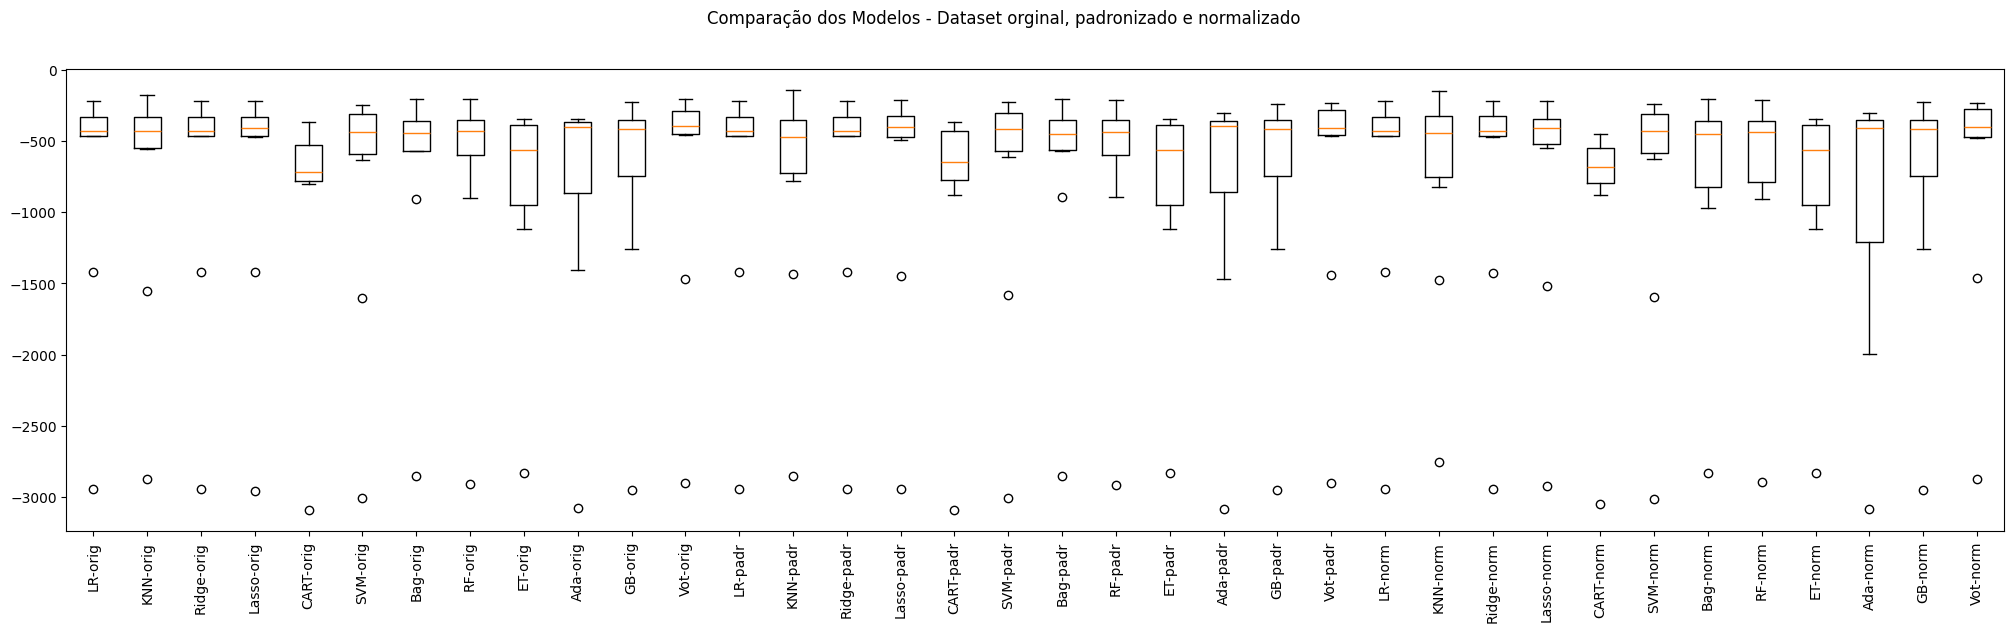

In [8]:
# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
resultados = []
nomes = []

# Criando os elementos do pipeline
modelos.append(('LR', LinearRegression()))
modelos.append(('Ridge', Ridge()))
modelos.append(('Lasso', Lasso()))
modelos.append(('KNN', KNeighborsRegressor())))
modelos.append(('CART', DecisionTreeRegressor()))
modelos.append(('SVM', SVR()))

# Algoritmos que serão utilizados
reg_lin = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR())
bagging = ('Bag', BaggingRegressor(estimator=base, n_estimators=num_trees, random_state=num_seed))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features, random_state=num_seed))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features, random_state=num_seed))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees, random_state=num_seed))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees, random_state=num_seed))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_lin])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_lin])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler,lasso])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_lin])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler,lasso])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for nome, modelo in pipelines:
    cv_resultados = cross_val_score(modelo, X_treino, y_treino, cv=kfold, scoring=scoring)
    resultados.append(cv_resultados)
    nomes.append(nome)
    # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (nome, abs(cv_resultados.mean()), cv_resultados.std(), np.sqrt(abs(cv_resultados.mean())))
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes, rotation=90)
plt.show()

### 4.3- Otimização dos Hiperparâmetros
Pela análise dos resultados dos modelos utilizados neste trabalho, o **Bagging** com **dados padronizados** apresentou melhor resultado (MSE 699,62 e RMSE 26,45).

Analisando apenas os modelos aplicados sobre os dados originais, o **Bagging** também performou melhor (MSE 701,07 e RMSE 26,48).

Para os dados normalizados, o **Bagging** já não apresentou a melhor performance, ficando atrás de outros modelos.

Dessa forma, será aplicada a otimização dos Hiperparâmetros sobre os modelos **Bagging**, na tentativa de melhorar a performance. O parâmetro selecionado será o número de modelos base a serem criados (n_estimators).

In [19]:
# Definindo os componentes do pipeline para o modelo Bagging
pipelines = []
pipelines.append(('Bag-orig', Pipeline(steps=[bagging])))
pipelines.append(('Bag-padr', Pipeline(steps=[standard_scaler, bagging])))
pipelines.append(('Bag-norm', Pipeline(steps=[min_max_scaler, bagging])))

# Definindo possíveis valores para o número de modelos bases a serem criados
param_grid = {
    'Bag__n_estimators': [60,80,100,120,140,160]
}

# Prepara e executa o GridSearchCV
for nome, modelo in pipelines:
    grid = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_treino, y_treino)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (nome, grid.best_score_, grid.best_params_))

Sem tratamento de missings: Bag-orig - Melhor: -698.994326 usando {'Bag__n_estimators': 175}
Sem tratamento de missings: Bag-padr - Melhor: -697.672841 usando {'Bag__n_estimators': 175}
Sem tratamento de missings: Bag-norm - Melhor: -735.559517 usando {'Bag__n_estimators': 175}


In [23]:
# Criando um modelo com todo o conjunto de treino
padronizado = StandardScaler().fit(X_treino) # ajuste do scaler com o conjunto de treino
X_padronizado = padronizado.transform(X_treino) # aplicação da padronização no conjunto de treino
modelo = BaggingRegressor(estimator=base, n_estimators=num_trees, random_state=num_seed)
modelo.fit(X_padronizado, y_treino)

# Fazendo as predições com o conjunto de teste
X_teste_padronizado = padronizado.transform(X_teste) # aplicação da padronização no conjunto de teste
predicoes = modelo.predict(X_teste_padronizado)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_teste, predicoes)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

modelo.fit(X, y)

# Teste com novos dados
#data = {'PLATAFORMA':  [4, 4, 2],
#        'TIPO': [1, 1, 0],
#        'PROPRIEDADE': [0, 1, 51],
#        'LDA': [0, 0, 0],
#        'BACIA': [1, 0, 1],
#        'RESTRICAO_QUEIMA': [1, 0, 1],
#        'TIPO_OPERACAO': [1, 0, 1],
#        'IDADE': [1, 10, 30],
#        }

#atributos = ['PLATAFORMA', 'TIPO', 'PROPRIEDADE', 'LDA', 'BACIA', 'RESTRICAO_QUEIMA', 'TIPO_OPERACAO', 'IDADE']
#entrada = pd.DataFrame(data, columns=atributos)

#array_entrada = entrada.values
#X_entrada = array_entrada[:,0:8]

#saidas = modelo.predict(X_entrada)
#print(saidas)

MSE 414.97
RMSE 20.37


BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                 random_state=7)